In [1]:
import numpy as np
import pandas as pd
from scipy.signal import lfilter, welch
from scipy import fftpack
import sys
import pylab as plt
from mne.viz import plot_topomap

def band_hilbert(x, fs, band, N=None, axis=-1):
    x = np.asarray(x)
    Xf = fftpack.fft(x, N, axis=axis)
    w = fftpack.fftfreq(x.shape[0], d=1. / fs)
    Xf[(w < band[0]) | (w > band[1])] = 0
    x = fftpack.ifft(Xf, axis=axis)
    return 2*x


def get_XY(x, y, n_taps, delay):
    X = np.array([x[n:n+n_taps][::-1].flatten() for n in range(len(x) - n_taps - max(0, -delay))])
    Y = np.array([y[n+n_taps-delay] for n in range(len(x) - n_taps - max(0, -delay))])
    return X, Y


def cLS(X, Y, lambda_=0):
    reg = lambda_*np.eye(X.shape[1])
    b = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X.conj())+reg), X.T.conj()), Y)
    return b

def corr(x, y):
    return np.corrcoef(x, y)[0, 1]

In [2]:
subj='nfb_13_mock'
x = np.load('{}.npy'.format(subj))
x = (x - x.mean(0))/x.std()
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'P4', 'P8', 'O1', 'Oz', 'O2', 'T7', 'Pz']
fs = 500
pos = np.load('ch_pos.npy')
if x.shape[1]==31:
    channels=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
    len(channels)
    pos = np.load('pos31.npy')
print(x.shape[1])

32


In [3]:
fs = 500
band = np.array((8, 12))
n_taps = 250
delays = np.arange(1, 250, 100)
indx, step = np.linspace(0, fs*7*60, 5, retstep=True, endpoint=False, dtype=int)
print(indx)
k=4
print('****', k)
x_train = x[:indx[k-2]+int(step)]
y_train = band_hilbert(x_train[:, channels.index('P4')], 500, band)
x_val = x[indx[k-1]:indx[k-1]+int(step)]
y_val = band_hilbert(x_val[:, channels.index('P4')], 500, band)
x_test = x[indx[k]:indx[k]+int(step)]
y_test = band_hilbert(x_test[:, channels.index('P4')], 500, band)
    
print(x_train.shape, x_val.shape, x_test.shape)

[     0  42000  84000 126000 168000]
**** 4
(126000, 32) (42000, 32) (42000, 32)


In [4]:
selected_ch = ['P4']
tests  = []
vals   = []
trains = []

for ch in channels:
    ch_indx =  [channels.index(sch) for sch in selected_ch]
    if ch not in selected_ch:
        ch_indx += [channels.index(ch)]
    X_train, Y_train = get_XY(x_train[:, ch_indx], y_train, n_taps, 0)
    X_val, Y_val = get_XY(x_val[:, ch_indx], y_val, n_taps, 0)
    X_test, Y_test = get_XY(x_test[:, ch_indx], y_test, n_taps, 0)
    indxes = np.arange(len(X_train))
    
    #indxes = np.random.randint(0, len(X_train), 10000)
    b = cLS(X_train[indxes], Y_train[indxes], 100)

    train = corr(np.abs(np.dot(X_train, b)), np.abs(Y_train))
    val  = corr(np.abs(np.dot(X_val, b)), np.abs(Y_val))
    test  = corr(np.abs(np.dot(X_test, b)), np.abs(Y_test))
    trains.append(train)
    tests.append(test)
    vals.append(val)
    print(selected_ch + [ch], train, val, test)

['P4', 'Fp1'] 0.796893435873 0.736002578958 0.755627335113
['P4', 'Fp2'] 0.805815833074 0.749116452272 0.763711923307
['P4', 'F7'] 0.798936738819 0.736039131354 0.757166741313
['P4', 'F3'] 0.797244995368 0.737278771811 0.756703448237
['P4', 'Fz'] 0.801476575903 0.743144829207 0.760230017463
['P4', 'F4'] 0.80776355567 0.755456604902 0.766223413011
['P4', 'F8'] 0.80692890622 0.753557943825 0.764888680169
['P4', 'Ft9'] 0.799536585042 0.73632132715 0.758014062872
['P4', 'Fc5'] 0.797500236449 0.735722128852 0.756933680816
['P4', 'Fc1'] 0.797185949285 0.737378045417 0.756824490458
['P4', 'Fc2'] 0.806590494264 0.750695065947 0.766625740149
['P4', 'Fc6'] 0.808429750697 0.757278786056 0.764333311333
['P4', 'Ft10'] 0.804897615921 0.744281184389 0.766043102946
['P4', 'C3'] 0.797508903856 0.73726703013 0.756248416698
['P4', 'Cz'] 0.79757933748 0.73710759347 0.757064640491
['P4', 'C4'] 0.806284948402 0.752646332248 0.764238788885
['P4', 'T8'] 0.80151234189 0.741617996811 0.760664133327
['P4', 'Tp9'

['P4' 'Cp2' 'Fc5' 'Fp1' 'F7' 'Ft9' 'T7' 'Cz' 'C3' 'F3' 'Fc1' 'P8' 'Tp10'
 'Cp5' 'Tp9' 'Cp1' 'P7' 'P3' 'Oz' 'T8' 'Pz' 'Fz' 'O1' 'Ft10' 'Cp6' 'O2'
 'Fp2' 'Fc2' 'C4' 'F8' 'F4' 'Fc6']


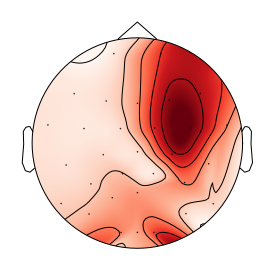

(<matplotlib.image.AxesImage at 0x7ffa9b6d8be0>,
 <matplotlib.contour.QuadContourSet at 0x7ffa9b6d89e8>)

In [5]:
tests1=np.array(vals[:len(channels)])
channels1 = np.array(channels)
print(channels1[np.argsort(tests1)])
plot_topomap(tests1[channels1!='P4']-tests1[channels1=='P4'], pos[channels1!='P4'])

['Fc6', 'F4', 'F8', 'C4', 'Fc2', 'Fp2', 'O2', 'Cp6', 'Ft10', 'O1', 'Fz', 'Pz', 'T8', 'Oz', 'P3', 'P7', 'Cp1', 'Tp9', 'Cp5', 'Tp10', 'P8', 'Fc1', 'F3', 'C3', 'Cz', 'T7', 'Ft9', 'F7', 'Fp1', 'Fc5', 'Cp2']
['P4'] 0.794727232589 0.734036194694 0.754756254353
['P4', 'Fc6'] 0.808429750697 0.757278786056 0.764333311333
['P4', 'Fc6', 'F4'] 0.81015711371 0.760503809753 0.767325673164
['P4', 'Fc6', 'F4', 'F8'] 0.812021347738 0.760374990676 0.766748041298
['P4', 'Fc6', 'F4', 'F8', 'C4'] 0.813895165936 0.761888171028 0.77151218022
['P4', 'Fc6', 'F4', 'F8', 'C4', 'Fc2'] 0.814573950766 0.762703148592 0.770921845247
['P4', 'Fc6', 'F4', 'F8', 'C4', 'Fc2', 'Fp2'] 0.815352159614 0.761604751391 0.769982179438
['P4', 'Fc6', 'F4', 'F8', 'C4', 'Fc2', 'Fp2', 'O2'] 0.819167272332 0.77179675308 0.779284276931
['P4', 'Fc6', 'F4', 'F8', 'C4', 'Fc2', 'Fp2', 'O2', 'Cp6'] 0.820564847222 0.77197259593 0.778806907848
['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'C3', 'Cz', '

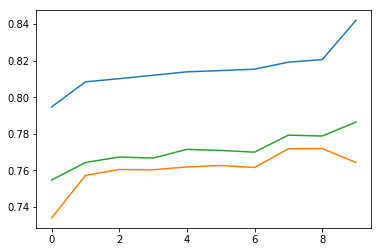

In [6]:
kbest_test = []
kbest_train = []
kbest_val = []
bs = []
chs = []

sorted_ch =  list(np.array(channels)[np.argsort(vals)][::-1])
sorted_ch.remove('P4')
print(sorted_ch)
for k in range(10):
    selected_ch = ['P4'] + sorted_ch[:k]
    if k==9:
        selected_ch = channels
    chs.append(selected_ch)
    ch_indx =  [channels.index(sch) for sch in selected_ch]
    X_train, Y_train = get_XY(x_train[:, ch_indx], y_train, n_taps, 0)
    X_val, Y_val = get_XY(x_val[:, ch_indx], y_val, n_taps, 0)
    X_test, Y_test = get_XY(x_test[:, ch_indx], y_test, n_taps, 0)
    indxes = np.arange(len(X_train))
    b = cLS(X_train[indxes], Y_train[indxes], 100)
    
    bs.append(b)
    
    train = corr(np.abs(np.dot(X_train, b)), np.abs(Y_train))
    test  = corr(np.abs(np.dot(X_test, b)), np.abs(Y_test))
    val  = corr(np.abs(np.dot(X_val, b)), np.abs(Y_val))
    
    kbest_train.append(train)
    kbest_test.append(test)
    kbest_val.append(val)
    print(selected_ch, train, val, test)
    
plt.plot(kbest_train)
plt.plot(kbest_val)
plt.plot(kbest_test)

[['P4'], ['P4', 'Cp5'], ['P4', 'Cp5', 'P7'], ['P4', 'Cp5', 'P7', 'F7'], ['P4', 'Cp5', 'P7', 'F7', 'C3'], ['P4', 'Cp5', 'P7', 'F7', 'C3', 'P3'], ['P4', 'Cp5', 'P7', 'F7', 'C3', 'P3', 'Cp2'], ['P4', 'Cp5', 'P7', 'F7', 'C3', 'P3', 'Cp2', 'Fp2'], ['P4', 'Cp5', 'P7', 'F7', 'C3', 'P3', 'Cp2', 'Fp2', 'Cp1'], ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft9', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'Ft10', 'C3', 'Cz', 'C4', 'T8', 'Tp9', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'Tp10', 'P7', 'P3', 'P4', 'P8', 'O1', 'Oz', 'O2', 'T7', 'Pz']]


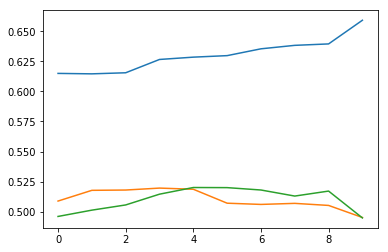

In [14]:
import pickle

a = [kbest_train, kbest_val, kbest_test, bs, chs, tests, vals, trains]

with open('results/{}.pkl'.format(subj), 'wb') as handle:
    pickle.dump(a, handle)

with open('results/{}.pkl'.format(subj), 'rb') as handle:
    [kbest_train, kbest_val, kbest_test, bs, chs, tests, vals, trains] = pickle.load(handle)

plt.plot(kbest_train)
plt.plot(kbest_val)
plt.plot(kbest_test)
print(chs)

(5000, 20000)

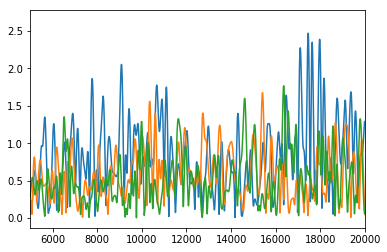

In [69]:
plt.plot(np.abs(y_val))
plt.plot(np.abs(y_test))
plt.plot(np.abs(y_train))
plt.xlim(5000, 20000)

In [70]:
corrs = []
for ch in  channels:
    # corrs.append(np.corrcoef(x_test[:,list(channels).index('P4')],x_test[:,list(channels).index(ch)])[0,1])
    #corrs.append(np.corrcoef(y_test.real,x_test[:,list(channels).index(ch)])[0,1])
    corrs.append(np.corrcoef(abs(y_test),abs(x_test[:,list(channels).index(ch)]))[0,1])

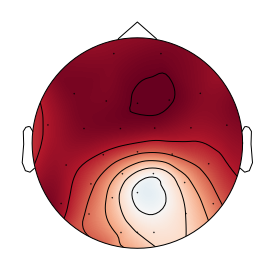

(<matplotlib.image.AxesImage at 0x7fa860b89be0>,
 <matplotlib.contour.QuadContourSet at 0x7fa860b89320>)

In [71]:
corrs=np.array(corrs)
channels = np.array(channels)
plot_topomap(-corrs[channels!='P4']+corrs[channels=='P4'], pos[channels!='P4'])

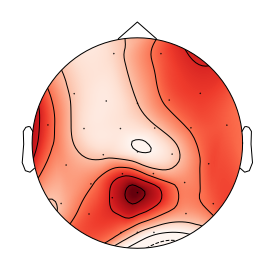

(<matplotlib.image.AxesImage at 0x7fa8609c34a8>,
 <matplotlib.contour.QuadContourSet at 0x7fa8609c3a20>)

In [72]:
trains=np.array(trains)
channels = np.array(channels)
plot_topomap(trains[channels!='P4']-trains[channels=='P4'], pos[channels!='P4'])

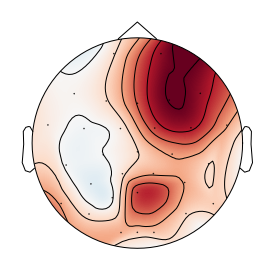

(<matplotlib.image.AxesImage at 0x7fa86006ef98>,
 <matplotlib.contour.QuadContourSet at 0x7fa86006eba8>)

In [73]:
tests=np.array(tests)
channels = np.array(channels)
plot_topomap(tests[channels!='P4']-tests[channels=='P4'], pos[channels!='P4'])

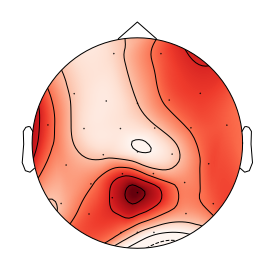

(<matplotlib.image.AxesImage at 0x7fa85ff537b8>,
 <matplotlib.contour.QuadContourSet at 0x7fa85ff53358>)

In [74]:
trains=np.array(trains)
channels = np.array(channels)
plot_topomap(trains[channels!='P4']-trains[channels=='P4'], pos[channels!='P4'])

In [75]:
opt_ch

NameError: name 'opt_ch' is not defined

In [76]:
channels[np.argmax(trains)], np.max(tests)

('Pz', 0.7627590902201441)

In [77]:
plt.plot(np.max(trains_it,1))
plt.plot(np.max(tests_it,1))

NameError: name 'trains_it' is not defined

In [78]:
ch_indx =  [channels.index(sch) for sch in selected_ch[:-1]]
X_train, Y_train = get_XY(x_train[:, ch_indx], y_train, n_taps, 0)
X_test, Y_test = get_XY(x_test[:, ch_indx], y_test, n_taps, 0)
indxes = np.arange(len(X_train))
b = cLS(X_train[indxes], Y_train[indxes], 100)

train = corr(np.abs(np.dot(X_train, b)), np.abs(Y_train))
test  = corr(np.abs(np.dot(X_test, b)), np.abs(Y_test))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [144]:

B = b.reshape(n_taps, -1)

(-0.02, 0.02)

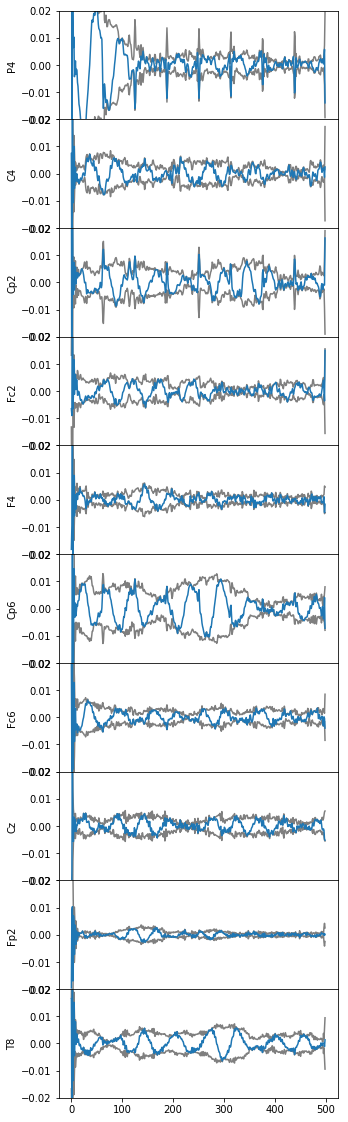

In [145]:
f, axes = plt.subplots(B.shape[1], sharex=True, sharey=True, figsize=(5, 20))
for j, ch in enumerate(selected_ch[:]):
    axes[j].plot(np.abs(B[:, j]), 'k', alpha=0.5)
    axes[j].plot(-np.abs(B[:, j]), 'k', alpha=0.5)
    axes[j].plot(np.real(B[:, j]))
    axes[j].set_ylabel(ch)

plt.subplots_adjust(hspace=0)
plt.ylim(-0.02, 0.02)

In [62]:
x_val

array([[ 0.65156775,  0.35457273,  0.33719701, ..., -0.63288759,
         0.57356422, -0.51082536],
       [ 0.54754915,  0.63044816,  0.20152057, ..., -0.55600428,
         0.15748979, -0.5153479 ],
       [ 0.21288058,  0.68924128, -0.0019941 , ..., -0.65550034,
        -0.33999051, -0.69624986],
       ..., 
       [-0.73233193, -0.4459183 , -0.2371666 , ...,  0.86859836,
        -0.86460607,  0.18564704],
       [-0.60117809, -0.43687318, -0.14671564, ...,  0.62438079,
        -0.71536198,  0.04997059],
       [-0.49715949, -0.49566633, -0.01103919, ..., -0.15349749,
        -0.44400913, -0.27113034]])

In [61]:
x_train

array([[ 0.24906097,  0.03347182,  1.1286429 , ..., -0.52434645,
         0.62783479, -0.3163558 ],
       [ 0.63800013,  0.16010317,  0.89347045, ..., -0.63288759,
         0.46502308, -0.60127634],
       [ 1.44753624,  0.49477174,  0.98392143, ..., -0.70977091,
         0.44693288, -0.86358412],
       ..., 
       [ 0.07268159, -0.50471141,  0.20152057, ..., -1.15750318,
         0.32934661, -1.15754976],
       [ 0.27619626, -0.31928693,  0.29197153, ..., -1.02182671,
         0.60974459, -0.91333215],
       [ 0.51136874, -0.01175366,  0.36433232, ..., -0.82283459,
         0.74542106, -0.664592  ]])

In [63]:
x_test

array([[-0.13987817, -0.64038784,  0.52262149, ..., -1.53739718,
         0.2705535 , -0.99473805],
       [ 0.09981689, -0.40069281,  0.80301947, ..., -1.47408161,
         0.69115045, -0.97212526],
       [ 0.2897639 , -0.23788108,  0.99748905, ..., -1.40624333,
         1.1434053 , -0.82740371],
       ..., 
       [-0.07656249,  0.54451977, -0.46781657, ...,  0.13142304,
        -0.2359719 , -1.00830567],
       [-0.24389677,  0.25055413, -0.47686165, ...,  0.00479169,
        -0.54350519, -1.04448608],
       [-0.41123105,  0.06060711, -0.59444792, ...,  0.0907201 ,
        -1.17666188, -1.03996354]])

In [68]:
X_train.shape

(99510, 1000)

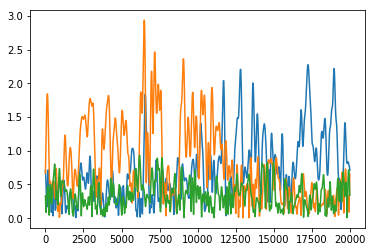

In [119]:
plt.plot(np.abs(y_train))
plt.plot(np.abs(y_val))
plt.plot(np.abs(y_test))

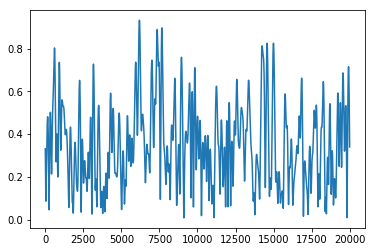

In [82]:
32*500


16000